# Predicting FMC with trained 10h Model

Model trained on hourly dead 10h. Applying model to local weather and comparing to field observations.

Geographic info from Mesonet slapout: https://www.mesonet.org/about/station-information?stid=slap

## Setup

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from src.models import moisture_rnn as mrnn
from src.utils import read_yml, time_intp, plot_styles

In [2]:
# Read Trained model
params = read_yml("models/params.yaml")
rnn = mrnn.RNN_Flexible(params=params)
scaler = joblib.load("models/scaler.joblib")

/Users/hirschij/Documents/Projects/Wildfire/fmc_transfer/src/models/moisture_rnn.py:483: UserWarning: timesteps should be None for flexible RNNs. Overriding to None.
  warnings.warn(f"{param} should be None for flexible RNNs. Overriding to None.")
/opt/anaconda3/envs/fmc/lib/python3.11/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
rnn.load_weights('models/rnn.keras')

/opt/anaconda3/envs/fmc/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Handle observed Carlson Data

In [4]:
weather = pd.read_excel("data/processed_data/dvdk_weather.xlsx")
fm10 = pd.read_excel("data/processed_data/ok_10h.xlsx")

In [5]:
# Calculate Variables
rh = weather.rh.copy()
temp = weather.temp.copy()
# Check if in C or K, convert to K if any below 100 degree
if np.any(temp<100):
    print("Converting C to F")
    temp += 273.15

Ed = 0.924 * rh**0.679 + 0.000499 * np.exp(0.1 * rh) + 0.18 * (21.1 + 273.15 - temp) * (1 - np.exp(-0.115 * rh))
Ew = 0.618 * rh**0.753 + 0.000454 * np.exp(0.1 * rh) + 0.18 * (21.1 + 273.15 - temp) * (1 - np.exp(-0.115 * rh))


# # Convert timezone from CST to UTC to line up with training
# weather['date'] = weather['date'].dt.tz_localize('Etc/GMT+6')
# weather['date'] = weather['date'].dt.tz_convert('UTC')
# fm10['date'] = fm10['date'].dt.tz_localize('Etc/GMT+6')
# fm10['date'] = fm10['date'].dt.tz_convert('UTC')

hod = weather.date.dt.hour
doy = weather.date.dt.dayofyear

print(f"All 1 hour spaced data: {weather['date'].diff().iloc[1:].eq(pd.Timedelta('1h')).all()}")

All 1 hour spaced data: True


In [6]:
# Geographic Variables from Slapout station
X = pd.DataFrame({
    "Ed": Ed,
    "Ew": Ew,
    "solar": weather["solar"],
    "wind": weather["wind"],
    "elev": 774,
    "lon": -100.261920,
    "lat": 36.597490,
    "rain": weather["rain"],
    "hod": hod,
    "doy": doy
})

print(f"Columns match: {np.all(X.columns == params['features_list'])}")

Columns match: True


In [7]:
# Get scaler from RNN Data
XX = scaler.transform(X)
XX = XX.reshape(1, *XX.shape)

/opt/anaconda3/envs/fmc/lib/python3.11/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [8]:
# Treating as a single batch
preds = rnn.predict(XX).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step


## Compare to observed

Issues to investigate:
- FMC sensors appear to have a maximal response to rain (see plot `data/SHQC1_0_4.png`).
    - Is this just FTS sensor? Or campbell too?
    - Will fine-tuning address this?
- 

In [9]:
inds = np.arange(24, 168*2+24)
dates = weather.date.iloc[inds]
fm_plt = fm10[(fm10.date >= dates.min()) & (fm10.date <= dates.max())]

Text(0.5, 1.0, 'Forecasted 10h Dead FMC from RNN - No Retrain')

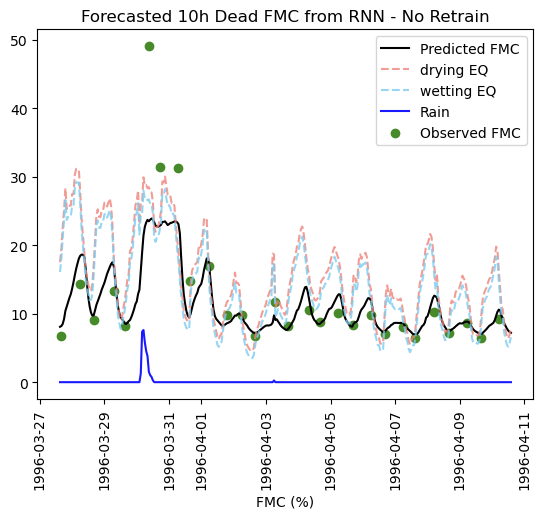

In [10]:
# Plotting first week of predictions, 
# ignoring first day as spinup
plt.plot(dates, preds[inds], **plot_styles["model"])
plt.plot(dates, X.Ed.iloc[inds], **plot_styles["Ed"])
plt.plot(dates, X.Ew.iloc[inds], **plot_styles["Ew"])
plt.plot(dates, X.rain.iloc[inds], **plot_styles["rain"])
plt.scatter(fm_plt.date, fm_plt.fm10, **plot_styles["fm"])
plt.xticks(rotation=90)
plt.legend()
plt.xlabel("FMC (%)")
plt.title("Forecasted 10h Dead FMC from RNN - No Retrain")

FMC Sensors (FTS only?) have a maximal response to rain...

![](data/SHQC1_0_4.png)

## Calculate Error

RNN predictions exactly on the hour, field observations are not. Using linear interpolation to line up RNN predictions to exact time of observed FMC.

In [11]:
# Linear interp Interp predictions to exact times of FMC
preds2 = time_intp(
    t1 = weather.date.to_numpy(),
    v1 = preds,
    t2 = fm10.date.to_numpy()
)

Text(0.5, 1.0, 'Forecasted RNN Interpolated to Exact Time of FMC Observation - No Retrain')

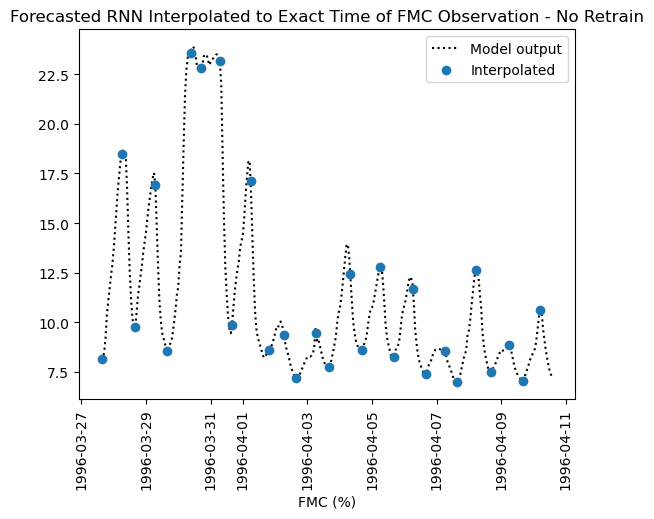

In [12]:
# Check interpolated preds first
inds = np.arange(24, 168*2+24)
dates = weather.date.iloc[inds]
df = fm10.copy()
df["preds"] = preds2
df2 = df[(df.date >= dates.min()) & (df.date <= dates.max())]

plt.plot(dates, preds[inds], color="k", linestyle="dotted", label="Model output")
plt.scatter(df2.date, df2.preds, label="Interpolated", zorder=2)
plt.xticks(rotation=90)
plt.legend()
plt.xlabel("FMC (%)")
plt.title("Forecasted RNN Interpolated to Exact Time of FMC Observation - No Retrain")

Overall RMSE: 6.592252985436501


Text(0.5, 1.0, 'Observed vs Predicted FMC')

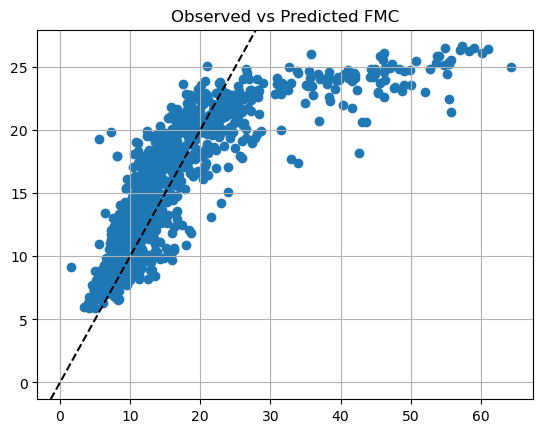

In [13]:
# Compare accuracy

print(f"Overall RMSE: {np.sqrt(mean_squared_error(df.fm10, df.preds))}")
plt.scatter(df.fm10, df.preds)
plt.grid()
plt.axline((0, 0), slope=1, color="k", linestyle="dashed", zorder=2)
plt.title("Observed vs Predicted FMC")

FM<= 30 RMSE: 2.869535144787357


Text(0.5, 1.0, 'Observed vs Predicted (<30% FMC)')

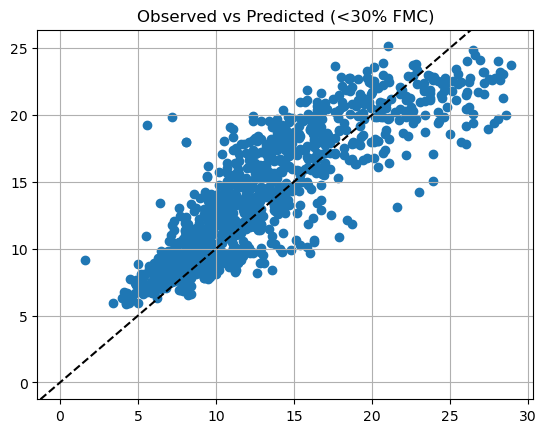

In [18]:
inds = np.where(df.fm10<30)[0]
print(f"FM<= 30 RMSE: {np.sqrt(mean_squared_error(df.fm10.iloc[inds], df.preds.iloc[inds]))}")
plt.scatter(df.fm10.iloc[inds], df.preds.iloc[inds])
plt.axline((0, 0), slope=1, color="k", linestyle="dashed", zorder=2)
plt.grid()
plt.title("Observed vs Predicted (<30% FMC)")